### Анализ полученных данных

In [1]:
import pandas as pd
import numpy as np

# импорт функций
from func_replace_letter import replace_letter as rep_let

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', sep=';')

In [3]:
data['dateTime'] = pd.to_datetime(data.dateTime, format='%Y-%m-%d %H:%M:%S')
# переводим столбец в формат даты и времени

Далее не много посмотрим на данные. В результате предварительного анализа, можем обнаружить, что наши данные имеют не корректное представление. Некоторые схожие с русскими буквами представлены на английском языке. Для того, чтобы это обнаружить, воспользуемся функцией `lower()`, которая переводит все символы в нижний регистр.

In [4]:
data.productName.str.lower()

0           cалаt "oлиbьe" (сoбствeh =
1      шоkoлад (мон' дэлис руcь) "ми =
2      печеньe (тулa) maффин "ильинс =
3      cыpоk глазир. (б.ю.aлеkсahдpо =
4      бx: бymагa тyалетhая "mягkий  =
                    ...               
321         п/ф карбoнад cвиhoй (п/ф =
322         pыба koпч.(арт-pыба) 3уб =
323    cmetahа (toтьмa) "boлогoдская =
324    cmеtаhа (тотьma) "bолoгoдckaя =
325     твоpoг (тотьмa) oбeзжирehhый =
Name: productName, Length: 326, dtype: object

Чтобы устранить не корректный ввод данных, создадим функцию `replace_letter`, которая заменяет английские символы на русские `k -> к` и возвращает исправленное наименование товара в нижнем регистре.

Функция описана в файле `func_replace_letter.py`

In [5]:
data['productName'] = data.productName.apply(rep_let)

In [6]:
print('Всего кол-во позиций:', data.shape[0], sep='\t')
# обратим внимание, что мы имеем 326 уникальных позиций товара
print('Всего кол-во чеков:', data.dateTime.nunique(), sep='\t')
# а также данные содержат всего 84 чека в промежутке с 1 апр.2022 по 8 нояб.2022

Всего кол-во позиций:	326
Всего кол-во чеков:	84


Данные загружены и отредактированы. С 1 апреля по 8 ноября имеется всего 84 чека, что является незначительным для такого промежутка времени. Сгруппируем данные по дате и визуализируем общую сумму покупок в каждом месяце.

In [7]:
data_group_date = data \
    .groupby('dateTime', as_index=False) \
    .agg({'purchaseAmount': 'sum'})

In [8]:
data_group_month = data.set_index(data.dateTime).purchaseAmount.resample('M').sum().to_frame().reset_index()

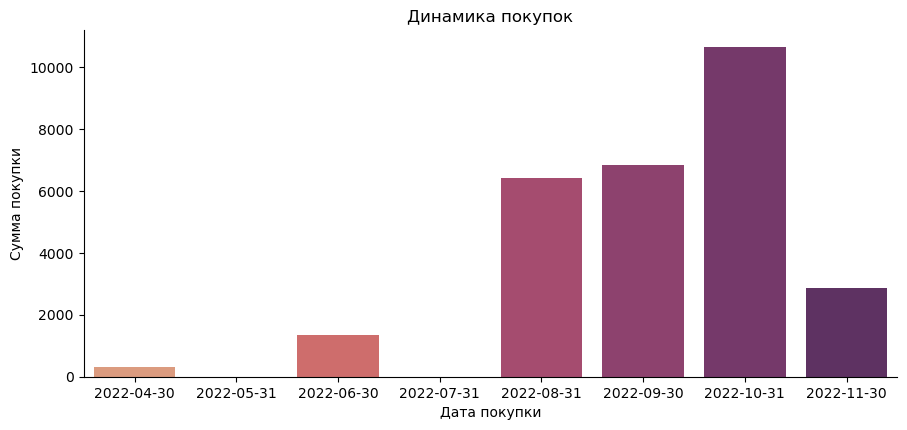

In [9]:
plt.figure(figsize=(10.5, 4.5))
ax = sns.barplot(data=data_group_month, x='dateTime', y='purchaseAmount',
                 palette="flare") # строим график
ax.set(xlabel='Дата покупки', ylabel='Сумма покупки', title='Динамика покупок') # именуем оси, наименовние графика
ax.set_xticklabels(data_group_month.dateTime.dt.date)
sns.despine() # убираем часть рамки
plt.show() # печатаем график

По данному графику можно сделать вывод, что с `апреля` по `июль` сумма покупок незначительна, поэтому для дальнейшего анализа оставим в выборке значения с `августа 2022` года.

In [10]:
data_active = data.query('dateTime > \'2022-07-31\'').reset_index(drop=True)
# отбираем данные с августа 2022 года

Для начала посмотрим частоту встречаемости каждой позиции товара и выберем наиболее популярные позиции.

In [11]:
data_active.productName.value_counts().head()

корм д/кошек "реrfест fiт" 75 =     17
для розницы: пакет-майка малый =    14
хлеб (вологодский хк) "дарниц =     14
газ.напиток (кириллов) о,5л с =     12
корм д/кошек "шеба" 75г в асс =     11
Name: productName, dtype: int64

По представленным выше данным мы видим `топ-5` позиций пользователя. На втором месте находится `пакет` - данный товар исключим из нашего `DataFrame` т.к. он не представляет для нас интереса.

In [12]:
data_active = data_active.drop(index = data_active \
    .query('productName == \'для розницы: пакет-майка малый =\'') \
    .index)

In [13]:
data_active.productName.value_counts().head()

корм д/кошек "реrfест fiт" 75 =    17
хлеб (вологодский хк) "дарниц =    14
газ.напиток (кириллов) о,5л с =    12
корм д/кошек "шеба" 75г в асс =    11
фрукты: бананы 1кг        =         9
Name: productName, dtype: int64

После удаления посторонних данных, вновь посмотрим на полученный `DataFrame`. `Топ-5` наиболее популярных позиции:
+ Корм д/кошек фирмы Perfect Fit
+ Хлеб Вологодский
+ Газ.напиток Кирилловский
+ Корм д/кошек фирмы Sheba
+ Фрукты "Бананы"

Для того, чтобы сделать однозначный вывод, давайте посмотрим, периодичность покупки каждой позиции.

In [14]:
data_active = data_active.assign(month=data_active.dateTime.dt.month)

In [15]:
top_5_product = data_active.productName.value_counts().head().index
# топ-5 наиболее популярных продуктов

In [16]:
data_top_5_product = data_active \
    .query('productName in @top_5_product')[['month', 'productName']]

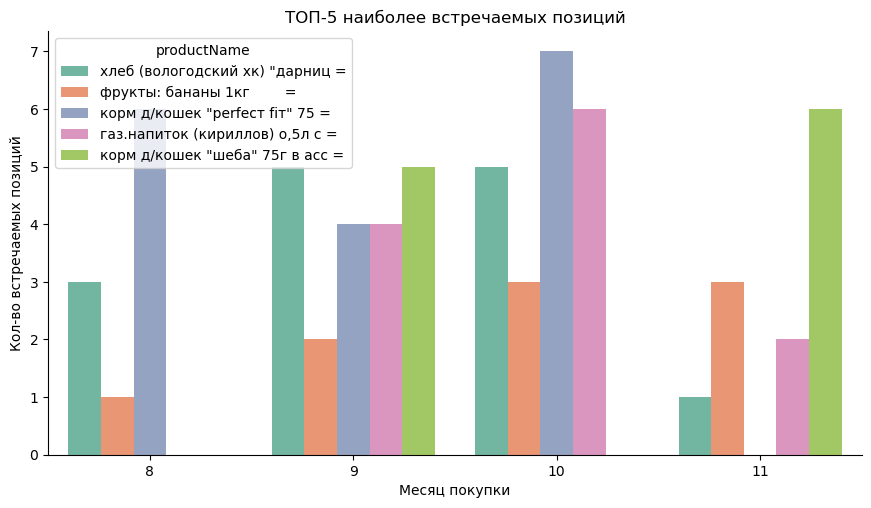

In [17]:
plt.figure(figsize=(10.5, 5.5))
ax = sns.countplot(data=data_top_5_product, x='month', hue='productName', palette="Set2") # строим график
ax.set(xlabel='Месяц покупки', ylabel='Кол-во встречаемых позиций',
       title='ТОП-5 наиболее встречаемых позиций') # именуем оси, наименовние графика
sns.despine() # убираем часть рамки
plt.show() # печатаем график

На графике можно увидеть, что данные позиции пользователь приобретает ежемесячно, что позволяет сделать следующий вывод.

**Вывод:** *при наличии купонов/скидок на данные `топ-5` позиций, можно уведомлять пользователя. Т.к. график показывает, что пользователь покупает данные позиции регулярно.*